In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from collections import Counter
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
import pandas as pd
from typing import List, Tuple
from dataclasses import dataclass
import scipy
from scipy.special import digamma
from scipy.special import gamma
from collections import defaultdict
import pprint
import os
import pickle

# Helpers

In [2]:
def cluster_likelihood(x, j, cluster_centers, m=2):
    if m == 1:
        return 1.0
    
    def weight(i):
        d_j = max(np.linalg.norm(x - cluster_centers[j]), 1e-12)
        d_i = max(np.linalg.norm(x - cluster_centers[i]), 1e-12)
        if d_j == d_i and d_j == 0.0:
            return 1
        return (d_j / d_i)**(2/(m-1))

    clusters = range(len(cluster_centers))
    w = 1 / (sum(map(lambda c : weight(c), clusters)))
    return w

def scale_from_01(value, min_value, max_value):
    old_min_value = 0.0
    old_max_value = 1.0
    return ((max_value - min_value)/(old_max_value - old_min_value)) * (value - old_min_value) + min_value

# between 0.0 and 1.0
def drift(mean, std):
    x = mean + np.random.normal(0.0, scale=std)
    x_tilda = abs(x)%2
    if x_tilda > 1.0:
        return 2 - x_tilda
    return x_tilda

def simulate_drift_in_bounds(min_value, max_value, std, horizon):
    assert min_value <= max_value
    value = np.random.uniform(low=0.0, high=1.0)
    means = np.zeros(horizon, dtype=np.float32)
    for i in range(0, horizon):
        means[i] = scale_from_01(value, min_value=min_value, max_value=max_value)
        value = drift(value, std)
    return means

pp = pprint.PrettyPrinter(width=100, compact=True)

# Simulate data points (drifting clusters)

In [3]:
HORIZON = 10000
NUM_CLUSTERS = 2

CLUSTER_CENTERS = np.array([
    [0.0, 0.0],
    [2.0, 2.0],
])

assert len(CLUSTER_CENTERS) == NUM_CLUSTERS

CLUSTER_STDS = np.array([0.0] * NUM_CLUSTERS, dtype=np.float32)

In [4]:
def simulate_center_drifts(init_centers, horizon):
    num_clusters = len(init_centers)
    offsets = np.zeros((horizon, num_clusters, 2), dtype=np.float32)
    for i in range(num_clusters):
        offsets[:, i, 0] = offsets[:, i, 0] + init_centers[i][0]
        offsets[:, i, 1] = offsets[:, i, 1] + init_centers[i][1]
    return offsets

CENTERS_DRIFT = simulate_center_drifts(init_centers=CLUSTER_CENTERS, horizon=HORIZON)

In [5]:
horizon = HORIZON

def simulate_blobs_drift(horizon, centers_drift, cluster_stds):
    X = np.zeros(shape=(horizon, 2), dtype=np.float32)
    y_true = np.zeros(shape=(horizon,), dtype=np.int32)

    for t in range(horizon):
        X_, y_true_ = make_blobs(
            n_samples=2, n_features=2,
            centers=centers_drift[t],
            cluster_std=cluster_stds
        )
        i = np.random.binomial(1, 0.5)
        X[t] = X_[i]
        y_true[t] = y_true_[i]
    
    return X, y_true 

X, y_true = simulate_blobs_drift(
    horizon=HORIZON,
    centers_drift=CENTERS_DRIFT,
    cluster_stds=CLUSTER_STDS
)

DATA_X = np.copy(X)
DATA_y_true = np.copy(y_true)

print(Counter(y_true))

Counter({0: 5015, 1: 4985})


In [6]:
SEQ_KMEANS_GAMMA = 1.0

class SequentialKMeans:
    def __init__(self, init_cluster_centers, gamma):
        assert 0.0 <= gamma <= 1.0
        self.gamma = gamma
        self.num_clusters = len(init_cluster_centers)
        self.cluster_centers = np.copy(init_cluster_centers)
        self.m = np.copy(self.cluster_centers)
        self.w = np.ones(self.num_clusters, dtype=float)

    def fit(self, x) -> int:
        """
        Fit a new data point x
        :param x: data point
        :return: cluster the data point assigned to
        """
        distances = np.linalg.norm(x - self.cluster_centers, axis=1)
        i = np.argmin(distances)
        self.m[i] = self.m[i] * self.gamma + x
        self.w[i] = self.w[i] * self.gamma + 1
        self.cluster_centers[i] = self.m[i] / self.w[i]
        return int(i)

kmeans = SequentialKMeans(CLUSTER_CENTERS, SEQ_KMEANS_GAMMA)
y = np.full(shape=len(DATA_y_true), fill_value=-1)

clusters_count = np.zeros(NUM_CLUSTERS, dtype=np.int32)
clusters_hit_count = np.zeros(NUM_CLUSTERS, dtype=np.int32)

for i in range(len(DATA_X)):
    y[i] = kmeans.fit(DATA_X[i])
assumed_clusters_hit = np.sum(DATA_y_true == y) / len(DATA_y_true)
print(f"clusters hit: {assumed_clusters_hit}")

clusters hit: 1.0


# Simulate action drift (means)

In [7]:
ACTIONS_DRIFT_STD = None
NUM_ACTIONS = 10

In [8]:
#actions_drift_base_path = None
actions_drift_base_path = "/nfs/notebooks/andrew/2024/experiments/64910"
ACTIONS_DRIFT = np.load(os.path.join(actions_drift_base_path, "ACTIONS_DRIFT.npy"))

### STATIONARY
    
# ACTIONS_DRIFT = np.zeros((HORIZON, NUM_CLUSTERS, NUM_ACTIONS), dtype=np.float32)
# cluster0_values = np.random.uniform(0.7, 1.0, size=NUM_ACTIONS)
# cluster1_values = np.random.uniform(0.0, 0.3, size=NUM_ACTIONS)
# assert NUM_CLUSTERS == 2
# for i in range(NUM_ACTIONS):
#     for t in range(HORIZON):
#         ACTIONS_DRIFT[t, 0, i] = cluster0_values[i]
#         ACTIONS_DRIFT[t, 1, i] = cluster1_values[i]

# idx = list(reversed(np.argsort(cluster0_values)))
# np.dstack((np.take(cluster0_values, idx), np.take(cluster1_values, idx)))

### NON-STATIONARY

# ACTIONS_DRIFT = np.zeros((HORIZON, NUM_CLUSTERS, NUM_ACTIONS), dtype=np.float32)

# def reward_drift(low, high):
#     return simulate_drift_in_bounds(min_value=low, max_value=high, std=ACTIONS_DRIFT_STD, horizon=HORIZON)

# # for j in range(NUM_CLUSTERS):
# #     for i in range(NUM_ACTIONS):
# #         ACTIONS_DRIFT[:, j, i] = reward_drift(0.0, 1.0)

# assert NUM_CLUSTERS == 2
# for i in range(NUM_ACTIONS):
#     ACTIONS_DRIFT[:, 0, i] = reward_drift(0.0, 0.3)
#     ACTIONS_DRIFT[:, 1, i] = reward_drift(0.7, 1.0)

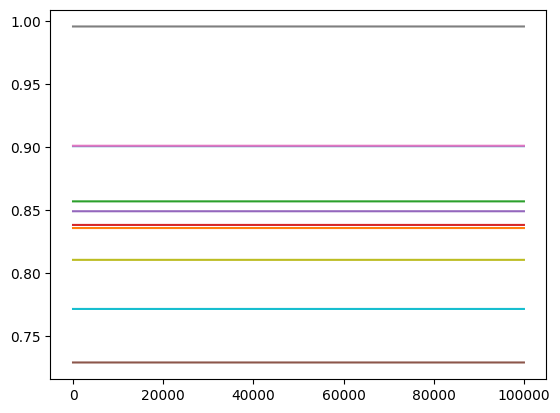

In [9]:
take=100000
for i in range(NUM_ACTIONS):
    plt.plot(range(0, take), ACTIONS_DRIFT[:take, 0, i])

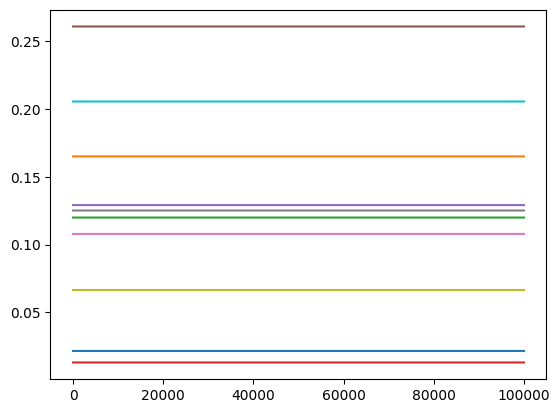

In [10]:
for i in range(NUM_ACTIONS):
    plt.plot(range(0, take), ACTIONS_DRIFT[:take, 1, i])

## Data

In [11]:
# for loading from the other experiments
# load_base_path = "/nfs/notebooks/andrew/2024/experiments/227927"
# CENTERS_DRIFT = np.load(os.path.join(load_base_path, "CENTERS_DRIFT.npy"))
# DATA_X = np.load(os.path.join(load_base_path, "DATA_X.npy"))
# DATA_y_true = np.load(os.path.join(load_base_path, "DATA_y_true.npy"))
# ACTIONS_DRIFT = np.load(os.path.join(load_base_path, "ACTIONS_DRIFT.npy"))

# Models

In [12]:
class EpsilonGreedy:
    def __init__(self, num_actions: int, horizon: int, epsilon: float):
        """
        Create EpsilonGreed policy playing the empirically best action
        with probability (1 - epsilon), otherwise explores uniformly at random.
        """
        if epsilon < 0.0 or epsilon > 1.0:
            raise ValueError(f"Epsilon {epsilon} must be in [0.0, 1.0]")
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.rewards = np.zeros(horizon, dtype=np.float32)
        self.cumulative_rewards = np.zeros(num_actions, dtype=np.float32)
        self.selected_actions = np.full(horizon, fill_value=-1, dtype=np.int32)
        self.actions_stats = np.zeros(num_actions, dtype=np.int32)

    def select(self, t: int) -> int:
        if np.random.random() < self.epsilon:
            self.selected_actions[t] = np.random.choice(self.num_actions)
        else:
            self.selected_actions[t], _ = self.empirically_best_action()            
        return self.selected_actions[t]

    def update(self, t: int, action: int, reward: float, phi: float):    
        if action != self.selected_actions[t]:
            raise ValueError(
                f"Expected the reward for action {self.selected_actions[t]}, but got for {action}"
            )
        self.rewards[t] = reward
        self.cumulative_rewards[action] += reward
        self.actions_stats[action] += 1
        return

    def empirically_best_action(self) -> Tuple[int, float]:
        if np.count_nonzero(self.cumulative_rewards) == 0:
            return np.random.choice(self.num_actions), 0.0
        idx = np.where(self.actions_stats != 0)
        i = np.argmax(self.cumulative_rewards[idx] / self.actions_stats[idx])
        action = idx[0][i]
        return action, self.cumulative_rewards[action] / self.actions_stats[action]

class UniformRandom:
    def __init__(self, num_actions: int, horizon: int):
        """
        Create a policy choosing an action uniformly at random.
        """
        self.num_actions = num_actions
        self.horizon = horizon
        self.rewards = np.zeros(horizon, dtype=np.float32)
        self.selected_actions = np.full(horizon, fill_value=-1, dtype=np.int32)

    def select(self, t: int) -> int:
        self.selected_actions[t] = np.random.choice(self.num_actions)
        return self.selected_actions[t]

    def update(self, t: int, action: int, reward: float, phi: float):
        if action != self.selected_actions[t]:
            raise ValueError(
                f"Expected the reward for action {self.selected_actions[t]}, but got for {action}"
            )
        self.selected_actions[t] = action
        self.rewards[t] = reward
        return

class DiscountedBetaThompsonSampling:
    def __init__(self, num_actions: int, horizon: int, gamma: float):
        """
        Create a discounted Thompson Sampling policy with Beta distribution as a prior one.
        """
        assert 0.0 <= gamma <= 1.0
        self.num_actions = num_actions
        self.horizon = horizon
        self.gamma = gamma
        self.alpha_0 = 1.0
        self.beta_0 = 1.0
        self.alphas = np.zeros(num_actions, dtype=float)
        self.betas = np.zeros(num_actions, dtype=float)
        self.rewards = np.zeros(horizon, dtype=np.float32)
        self.selected_actions = np.full(horizon, fill_value=-1, dtype=np.int32)

    def select(self, t: int) -> int:
        samples = np.zeros(self.num_actions, dtype=float)
        for i in range(self.num_actions):
            alpha = self.alphas[i] + self.alpha_0
            beta = self.betas[i] + self.beta_0
            samples[i] = np.random.beta(alpha, beta)
        self.selected_actions[t] = int(np.argmax(samples))
        return self.selected_actions[t]

    def update(self, t: int, action: int, reward: float, phi: float):
        assert 0.0 <= phi <= 1.0
        if action != self.selected_actions[t]:
            raise ValueError(
                f"Expected the reward for action {self.selected_actions[t]}, but got for {action}"
            )

        self.selected_actions[t] = action
        self.rewards[t] = reward

# NOTE: NOT PLAYED ACTIONS ARE NOT DISCOUNTED
#         for i in range(self.num_actions):
#             self.alphas[i] = self.gamma * self.alphas[i]
#             self.betas[i] = self.gamma * self.betas[i]
#         self.alphas[action] += phi * reward
#         self.betas[action] += phi * (1.0 - reward)
        self.alphas[action] = self.gamma * self.alphas[action] + phi * reward
        self.betas[action] = self.gamma * self.betas[action] + phi * (1.0 - reward)
    
class BernoulliBandit:
    def __init__(self, init_means: np.ndarray, horizon: int):
        self.largest_means = np.zeros(horizon, dtype=float)
        self.optimal_actions = np.full(horizon, fill_value=-1, dtype=int)
        self.means = init_means

    def draw(self, t: int, action: int) -> float:
        self.optimal_actions[t] = np.argmax(self.means)
        self.largest_means[t] = self.means[self.optimal_actions[t]]
        p = self.means[action]
        return np.random.binomial(n=1, p=p)

# Experiment

In [13]:
base_path = os.path.join("/nfs/notebooks/andrew/2024/experiments", str(np.random.randint(0, 1000000)))
os.mkdir(base_path)
print(base_path)
np.save(os.path.join(base_path, "ACTIONS_DRIFT.npy"), ACTIONS_DRIFT)
np.save(os.path.join(base_path, "DATA_X.npy"), DATA_X)
np.save(os.path.join(base_path, "DATA_y_true.npy"), DATA_y_true)
np.save(os.path.join(base_path, "CENTERS_DRIFT.npy"), CENTERS_DRIFT)

DBTS = DiscountedBetaThompsonSampling

horizon = HORIZON
num_experiments = 5000
num_actions = NUM_ACTIONS
num_clusters = NUM_CLUSTERS

X = DATA_X[:horizon]
y_true = DATA_y_true[:horizon]

seq_kmeans_gamma = SEQ_KMEANS_GAMMA

class Policy:    
    def __init__(self, name, instances, horizon, gamma, m, eps):
        self.name = name
        self.instances = instances  # one per cluster
        self.gamma = gamma
        self.m = m  # when m is None, phi stays 1.0
        self.eps = eps  # for epsilon-greedy
    def to_dict(self):
        return {"name": self.name, "gamma": self.gamma, "m": self.m, "eps": self.eps}

def build_uniform_random():
    instances = [UniformRandom(num_actions, horizon) for i in range(NUM_CLUSTERS)]
    return Policy(name = "UR", instances = instances, horizon = horizon, gamma=None, m = None, eps = None)
        
def build_eps_greedy(eps):
    instances = [EpsilonGreedy(num_actions, horizon, eps) for i in range(NUM_CLUSTERS)]
    return Policy(name = "EG", instances = instances, horizon = horizon, gamma=None, m = None, eps = eps)

def build_DBTS(gamma, m):
    instances = [DBTS(num_actions, horizon, gamma=gamma) for i in range(NUM_CLUSTERS)]
    return Policy(name = "DTS", instances = instances, horizon = horizon, gamma=gamma, m = m, eps = None)

num_baselines = 2  # first policies to compare with
def build_policies():
    return [
        build_DBTS(gamma=1.0, m=None),
        build_DBTS(gamma=1.0, m=None),
        build_DBTS(gamma=1.0, m=1.3),
        build_DBTS(gamma=1.0, m=1.3),
    ]
num_policies = len(build_policies())

settings = {
    "num_experiments": num_experiments,
    "num_clusters": num_clusters,
    "num_actions": num_actions,
    "horizon": horizon,
    "num_policies": num_policies,
    "CLUSTER_STDS": CLUSTER_STDS,
    "CLUSTER_CENTERS": CLUSTER_CENTERS,
    "assumed_clusters_hit": assumed_clusters_hit,
    "seq_kmeans_gamma": seq_kmeans_gamma,
    "ACTIONS_DRIFT_STD": ACTIONS_DRIFT_STD,
    "policies": [p.to_dict() for p in build_policies()],
    "actions_drift_base_path": actions_drift_base_path,
}
np.save(os.path.join(base_path, "settings.npy"), settings)
pp.pprint(settings)

assert num_actions < 128
assert num_clusters < 128
selected_actions = np.full((num_experiments, num_policies, num_clusters, horizon), fill_value=-1, dtype=np.int8)
total_regrets = np.zeros((num_experiments, num_policies), dtype=np.float32)
predicted_clusters = np.full((num_experiments, horizon), fill_value=-1, dtype=np.int8)
clusters_count = np.zeros((num_experiments, num_clusters), dtype=np.uint32)
clusters_hit_count = np.zeros((num_experiments, num_clusters), dtype=np.uint32)

for exp_id in range(num_experiments):    
    envs = [BernoulliBandit(init_means=ACTIONS_DRIFT[0, i, :], horizon=horizon) for i in range(NUM_CLUSTERS)]
    kmeans = SequentialKMeans(init_cluster_centers=CLUSTER_CENTERS, gamma=seq_kmeans_gamma)
    policies = build_policies()
    
    true_largest_means = np.zeros(horizon, dtype=np.float32)  # should the same across experiments
    rewards = np.full((num_policies, horizon), fill_value=-1, dtype=np.float32)
    
    for t in range(horizon):
        for i in range(NUM_CLUSTERS):
            envs[i].means = ACTIONS_DRIFT[t, i, :]

        x = X[t]

        true_cluster = y_true[t]
        predicted_cluster = kmeans.fit(x)
        predicted_clusters[exp_id, t] = predicted_cluster

        clusters_count[exp_id, true_cluster] += 1
        if true_cluster == predicted_cluster:
            clusters_hit_count[exp_id, true_cluster] += 1

        true_largest_means[t] = np.max(envs[true_cluster].means)
        
        for policy_id, policy in enumerate(policies):
            instance = policy.instances[predicted_cluster] # cluster miss possibility

            action = instance.select(t)
            reward = envs[true_cluster].draw(t=t, action=action)
            rewards[policy_id, t] = reward

            phi = 1.0
            if policy.m:
                phi = cluster_likelihood(x=x, j=predicted_cluster, cluster_centers=kmeans.cluster_centers, m=policy.m)
            instance.update(t=t, action=action, reward=reward, phi=phi)

    exp_path = os.path.join(base_path, str(exp_id)); os.mkdir(exp_path)
    np.save(os.path.join(exp_path, "true_largest_means.npy"), true_largest_means)
    np.save(os.path.join(exp_path, "rewards.npy"), rewards)

    for policy_id, policy in enumerate(policies):
        total_regrets[exp_id][policy_id] = np.sum(true_largest_means) - np.sum(rewards[policy_id, :])        
        for cluster_id, instance in enumerate(policy.instances):
            selected_actions[exp_id, policy_id, cluster_id, :] = instance.selected_actions

    print(f"{exp_id}", end='\r')

np.save(os.path.join(base_path, "selected_actions.npy"), selected_actions)
np.save(os.path.join(base_path, "total_regrets.npy"), total_regrets)
np.save(os.path.join(base_path, "predicted_clusters.npy"), predicted_clusters)
np.save(os.path.join(base_path, "clusters_count.npy"), clusters_count)
np.save(os.path.join(base_path, "clusters_hit_count.npy"), clusters_hit_count)
print(f"\nclusters count: {np.mean(clusters_count, axis=0)}")
print(f"clusters hit: {np.mean(clusters_hit_count / clusters_count, axis=0)}")

def uplift(base_id: int, policy_id: int):
    if base_id == policy_id:
        return ""
    base_val = np.mean(total_regrets[:, base_id])
    policy_val = np.mean(total_regrets[:, policy_id])
    perc = ((policy_val - base_val) / base_val) * 100
    return f"{round(perc, 2)}%"

output = defaultdict(list)
for i in range(len(settings["policies"])):
    output["name"].append(settings["policies"][i]["name"])
    output["gamma"].append(settings["policies"][i]["gamma"])
    output["m"].append(settings["policies"][i]["m"])
    output["eps"].append(settings["policies"][i]["eps"])
    output["regret (mean)"].append(np.mean(total_regrets[:, i]))
    output["std"].append(np.std(total_regrets[:, i]))
    output["min"].append(np.min(total_regrets[:, i]))
    output["max"].append(np.max(total_regrets[:, i]))
    for j in range(num_baselines):
        output[f"against #{j}"].append(uplift(base_id=j, policy_id=i))

df = pd.DataFrame(data=output)
df.to_csv(os.path.join(base_path, "table.csv"), encoding='utf-8', index=False)
df

/nfs/notebooks/andrew/2024/experiments/14517
{'ACTIONS_DRIFT_STD': None,
 'CLUSTER_CENTERS': array([[0., 0.],
       [2., 2.]]),
 'CLUSTER_STDS': array([0., 0.], dtype=float32),
 'actions_drift_base_path': '/nfs/notebooks/andrew/2024/experiments/64910',
 'assumed_clusters_hit': 1.0,
 'horizon': 10000,
 'num_actions': 10,
 'num_clusters': 2,
 'num_experiments': 5000,
 'num_policies': 4,
 'policies': [{'eps': None, 'gamma': 1.0, 'm': None, 'name': 'DTS'},
              {'eps': None, 'gamma': 1.0, 'm': None, 'name': 'DTS'},
              {'eps': None, 'gamma': 1.0, 'm': 1.3, 'name': 'DTS'},
              {'eps': None, 'gamma': 1.0, 'm': 1.3, 'name': 'DTS'}],
 'seq_kmeans_gamma': 1.0}
4999
clusters count: [5015. 4985.]
clusters hit: [1. 1.]


,name,gamma,m,eps,regret (mean),std,min,max,against #0,against #1
0,DTS,1.0,NaN,None,109.058327,41.303890,-17.280273,429.719727,,0.38%
1,DTS,1.0,NaN,None,108.650528,42.438950,-38.280273,393.719727,-0.37%,
2,DTS,1.0,1.3,None,109.336525,41.705112,-28.280273,449.719727,0.26%,0.63%
3,DTS,1.0,1.3,None,109.518723,41.077690,-33.280273,433.719727,0.42%,0.8%


## New summary

In [14]:
def summary(experiment_ids, horizon_start = 0, horizon_stop = horizon, with_true_classif = True, with_false_classif = True):
    y_true = np.load(os.path.join(base_path, "DATA_y_true.npy"))[horizon_start:horizon_stop]
    # we assume that predicted clusters are the same across experiments 
    predicted_clusters = np.load(os.path.join(base_path, "predicted_clusters.npy"))
    assert np.size(predicted_clusters[0]) == np.sum(predicted_clusters[0] == predicted_clusters[np.random.choice(experiment_ids)])
    predicted_clusters = predicted_clusters[0][horizon_start:horizon_stop]

    if with_true_classif and with_false_classif:
        step_ids = list(range(horizon_start, horizon_stop))
    elif with_true_classif:
        step_ids = np.flatnonzero(y_true == predicted_clusters)
    elif with_false_classif:
        step_ids = np.flatnonzero(y_true != predicted_clusters)
    else:
        raise ValueError("both flags False")
    
    regrets = np.zeros((len(experiment_ids), num_policies), dtype=np.float32)
    for i, exp_id in enumerate(experiment_ids):
        exp_path = os.path.join(base_path, str(exp_id))
        true_largest_means = np.load(os.path.join(exp_path, "true_largest_means.npy"))
        rewards = np.load(os.path.join(exp_path, "rewards.npy"))
        for policy_id in range(num_policies):
            best_means = np.sum(true_largest_means.take(step_ids))
            policy_rewards = np.sum(rewards[policy_id].take(step_ids))
            regrets[i][policy_id] = best_means - policy_rewards
        print(f"{i}", end='\r')

    def uplift(base_id: int, policy_id: int):
        if base_id == policy_id:
            return ""
        base_val = np.mean(regrets[:, base_id])
        policy_val = np.mean(regrets[:, policy_id])
        perc = ((policy_val - base_val) / base_val) * 100
        return f"{round(perc, 2)}%"

    output = defaultdict(list)
    for i in range(len(settings["policies"])):
        output["name"].append(settings["policies"][i]["name"])
        output["gamma"].append(settings["policies"][i]["gamma"])
        output["m"].append(settings["policies"][i]["m"])
        output["eps"].append(settings["policies"][i]["eps"])
        output["regret (mean)"].append(np.mean(regrets[:, i]))
        output["std"].append(np.std(regrets[:, i]))
        output["min"].append(np.min(regrets[:, i]))
        output["max"].append(np.max(regrets[:, i]))
        for j in range(num_baselines):
            output[f"against #{j}"].append(uplift(base_id=j, policy_id=i))

    return pd.DataFrame(data=output)

In [15]:
summary(experiment_ids=range(0, num_experiments), horizon_start = 0, horizon_stop = horizon, with_true_classif = True, with_false_classif = True)

,name,gamma,m,eps,regret (mean),std,min,max,against #0,against #1
0,DTS,1.0,NaN,None,109.058327,41.303890,-17.280273,429.719727,,0.38%
1,DTS,1.0,NaN,None,108.650528,42.438950,-38.280273,393.719727,-0.37%,
2,DTS,1.0,1.3,None,109.336525,41.705112,-28.280273,449.719727,0.26%,0.63%
3,DTS,1.0,1.3,None,109.518723,41.077690,-33.280273,433.719727,0.42%,0.8%


In [16]:
summary(experiment_ids=range(0, num_experiments), horizon_start = 0, horizon_stop = horizon, with_true_classif = True, with_false_classif = False)

,name,gamma,m,eps,regret (mean),std,min,max,against #0,against #1
0,DTS,1.0,NaN,None,109.058327,41.303890,-17.280273,429.719727,,0.38%
1,DTS,1.0,NaN,None,108.650528,42.438950,-38.280273,393.719727,-0.37%,
2,DTS,1.0,1.3,None,109.336525,41.705112,-28.280273,449.719727,0.26%,0.63%
3,DTS,1.0,1.3,None,109.518723,41.077690,-33.280273,433.719727,0.42%,0.8%


In [17]:
summary(experiment_ids=range(0, num_experiments), horizon_start = 0, horizon_stop = horizon, with_true_classif = False, with_false_classif = True)

/tmp/ipykernel_2532/198681352.py:33: RuntimeWarning: invalid value encountered in float_scalars
  perc = ((policy_val - base_val) / base_val) * 100


,name,gamma,m,eps,regret (mean),std,min,max,against #0,against #1
0,DTS,1.0,NaN,None,0.0,0.0,0.0,0.0,,nan%
1,DTS,1.0,NaN,None,0.0,0.0,0.0,0.0,nan%,
2,DTS,1.0,1.3,None,0.0,0.0,0.0,0.0,nan%,nan%
3,DTS,1.0,1.3,None,0.0,0.0,0.0,0.0,nan%,nan%


In [18]:
def draw_acc_regret(experiment_ids, horizon, policy_ids, with_true_classif = True, with_false_classif = True):
    y_true = np.load(os.path.join(base_path, "DATA_y_true.npy"))[:horizon]
    # we assume that predicted clusters are the same across experiments 
    predicted_clusters = np.load(os.path.join(base_path, "predicted_clusters.npy"))
    assert np.size(predicted_clusters[0]) == np.sum(predicted_clusters[0] == predicted_clusters[np.random.choice(experiment_ids)])
    predicted_clusters = predicted_clusters[0][:horizon]

    if with_true_classif and with_false_classif:
        step_ids = list(range(0, horizon))
    elif with_true_classif:
        step_ids = np.flatnonzero(y_true == predicted_clusters)
    elif with_fase_classif:
        step_ids = np.flatnonzero(y_true != predicted_clusters)
    else:
        raise ValueError("both flags False")

    regrets = np.zeros((len(policy_ids), len(experiment_ids), len(step_ids)), dtype=np.float32)
        
    for i, exp_id in enumerate(experiment_ids):
        exp_path = os.path.join(base_path, str(exp_id))        
        true_largest_means = np.load(os.path.join(exp_path, "true_largest_means.npy"))
        rewards = np.load(os.path.join(exp_path, "rewards.npy"))

        for j, policy_id in enumerate(policy_ids):
            regrets[j, i] = true_largest_means.take(step_ids) - rewards[policy_id].take(step_ids)
            for t in range(1, len(step_ids)):
                regrets[j, i][t] += regrets[j, i][t-1]
        print(f"{i}", end='\r')

    for j, policy_id in enumerate(policy_ids):
        _regrets = np.mean(regrets[j], axis=0)
        plt.plot(range(0, len(step_ids)), _regrets, label=f"{policy_id}")
    plt.legend()
    plt.show()

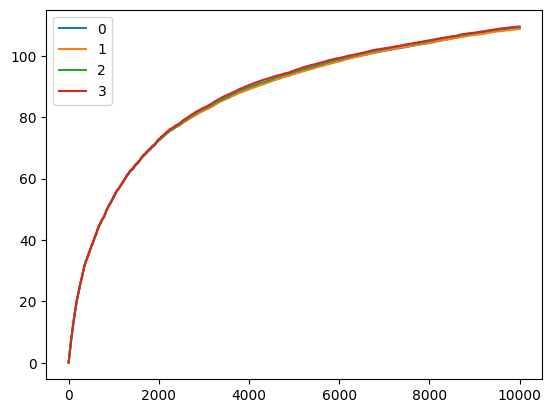

In [19]:
draw_acc_regret(experiment_ids=range(0, num_experiments), horizon=horizon, policy_ids=range(num_policies))

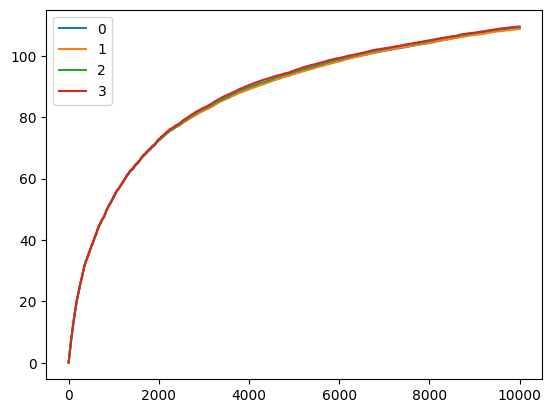

In [20]:
draw_acc_regret(experiment_ids=range(0, num_experiments), horizon=horizon, policy_ids=range(num_policies), with_true_classif = True, with_false_classif = False)